# Housing Unit Allocation Full Workflow

## Overview
Given a building inventory that uses IN-CORE standard columns, run housing unit allocation.
This process checks to see if the housing unit inventory is available and if not it will create it.
This process checks to see if the address point inventory is available and if not it will create it.

With the housing unit inventory and address point inventory created, they will be uploaded to IN-CORE Dataservice.

With the required files on IN-CORE Dataservice, the housing unit allocation method will run.
Functions are provided to obtain and clean data required for the version 2 Housing Unit Allocation. 

## Required Inputs
Program requires the following inputs:
1. Building inventory file from pyincore
    - IN-CORE account
    
## Output Description
The output of this workflow is a CSV file with the housing unit inventory allocated to a building inventory using the housing unit allocation model.

The output CSV is designed to be used in the Interdependent Networked Community Resilience Modeling Environment (IN-CORE).

IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/


## Instructions
Users can run the workflow by executing each block of code in the notebook.

## Description of Program
- program:    ncoda_07cv4_run_HUA_workflow
- task:       Start with building inventory and run housing unit allocation algorithm
- See github commits for description of program updates
- Current Version: 2023-01-27 - Generalize workflow using new Lumberton Building Data
- 2022-08-29 - v2 workflow
- 2022-10-06 - clean up code and test output for Salt Lake City
- project:    Interdependent Networked Community Resilience Modeling Environment (IN-CORE), Subtask 5.2 - Social Institutions
- funding:	  NIST Financial Assistance Award Numbers: 70NANB15H044 and 70NANB20H008 
- author:     Nathanael Rosenheim

- Suggested Citation:
Rosenheim, Nathanael (2021) “Detailed Household and Housing Unit Characteristics: Data and Replication Code.” DesignSafe-CI. 
https://doi.org/10.17603/ds2-jwf6-s535.

## Setup Python Environment

In [1]:
import pandas as pd
import geopandas as gpd # For reading in shapefiles
import numpy as np
import sys # For displaying package versions
import os # For managing directories and file paths if drive is mounted

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage.buildingdamage import BuildingDamage

from pyincore_viz.geoutil import GeoUtil as viz

In [2]:
# https://ipyleaflet.readthedocs.io/en/latest/api_reference/heatmap.html
import ipyleaflet as ipylft
from ipyleaflet import Map, Heatmap, LayersControl

In [3]:
# To reload submodules need to use this magic command to set autoreload on
%load_ext autoreload
%autoreload 2
# open, read, and execute python program with reusable commands
from pyncoda.ncoda_00b_directory_design import directory_design
from pyncoda.ncoda_00e_geoutilities import spatial_join_points_to_poly
from pyncoda.ncoda_07a_generate_hui import generate_hui_functions
from pyncoda.ncoda_07c_generate_addpt import generate_addpt_functions
from pyncoda.ncoda_07d_run_hua_workflow import hua_workflow_functions


In [4]:
import scooby # Reports Python environment

In [5]:
# Generate report of Python environment
print(scooby.Report(additional=['pandas','pyincore','pyincore_viz','ipyleaflet']))


--------------------------------------------------------------------------------
  Date: Fri Jan 27 16:50:49 2023 Central Standard Time

                OS : Windows
            CPU(s) : 12
           Machine : AMD64
      Architecture : 64bit
               RAM : 31.6 GiB
       Environment : Jupyter

  Python 3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:50:36) [MSC
  v.1929 64 bit (AMD64)]

            pandas : 1.5.0
          pyincore : 1.7.0
      pyincore_viz : Version unknown
        ipyleaflet : 0.17.1
             numpy : 1.23.3
             scipy : 1.9.1
           IPython : 8.5.0
        matplotlib : 3.6.0
            scooby : 0.5.12
--------------------------------------------------------------------------------


In [6]:
# Check working directory - good practice for relative path access
os.getcwd()

'c:\\Users\\nathanael99\\MyProjects\\IN-CORE\\Tasks\\PublishHUIv2\\HousingUnitInventories_2022-03-03\\ReplicationCode\\intersect-community-data'

### Required Information: 
#### Residential Building Variable
What variable has information to determine if building is residential or not?
County observations by variable


In [7]:
Nofal_residential_archetypes = { 
        1 : 'One-story sf residential building on a crawlspace foundation',
        2 : 'One-story mf residential building on a slab-on-grade foundation',
        3 : 'Two-story sf residential building on a crawlspace foundation',
        4 : 'Two-story mf residential building on a slab-on-grade foundation'}

Nofal_residential_archetypesv2 = { 
        1 : {'Description' : 
                'One-story sf residential building on a crawlspace foundation',
             'HU estimate' : 1},
        2 : {'Description' : 
                'One-story mf residential building on a slab-on-grade foundation',
              'HU estimate' : 1},
        3 : {'Description' : 
                'Two-story sf residential building on a crawlspace foundation',
            'HU estimate' : 1},
        4 : {'Description' : 
                'Two-story mf residential building on a slab-on-grade foundation',
            'HU estimate' : 1}
            }


# HAZUS Archetypes for residential buildings include an estimate of housing units
HAZUS_residential_archetypes = { 
    "RES1" : {'Description' : "Single Family Dwelling", 'HU estimate' : 1},
    "RES2" : {'Description' : "Mobile / Manufactured Home", 'HU estimate' : 1},
    "RES3A" : {'Description' : "Duplex", 'HU estimate' : 2},
    "RES3B" : {'Description' : "3-4 Units", 'HU estimate' : 3},
    "RES3C" : {'Description' : "5-9 Units", 'HU estimate' : 7},
    "RES3D" : {'Description' : "10-19 Units", 'HU estimate' : 15},
    "RES3E" : {'Description' : "20-49 Units", 'HU estimate' : 30},
    "RES3F" : {'Description' : "50+ Units", 'HU estimate' : 50},
    "RES4" : {'Description' : "Temporary Lodging", 'HU estimate' : 1},
    "RES5" : {'Description' : "Institutional Dormitory", 'HU estimate' : 1},
    "RES6" : {'Description' : "Nursing Home", 'HU estimate' : 1}
    }

residential_archetypes = Nofal_residential_archetypesv2 

In [8]:
# Edit Data Dictionary for Community

# Example of data dictionary for one community with one county
# Check how to capitalize the state name at
## https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/

# NOTE on file path length. WINDOWS has a limit of 260 characters for file path length.
# Community name needs to be short to avoid this limit.

communities = {'Lumberton_NC' : {
                    'community_name' : 'Lumberton, NC',
                    'STATE' : 'NORTH_CAROLINA',
                    'years' : ['2010'],
                    'counties' : { 
                        1 : {'FIPS Code' : '37155', 'Name' : 'Robeson County, NC'}},
                    'building_inventory' : { 
                        'id' : '62ab7dcbf328861e25ffea9e',
                        'note' : 'Building inventory for Robeson County, NC',
                        'archetype_var' : 'archetype',
                        'building_area_var' : 'sq_foot'}
                                }
                }

version = '2.0.0'
version_text = 'v2-0-0'

# Save Outputfolder - due to long folder name paths output saved to folder with shorter name
# files from this program will be saved with the program name - 
# this helps to follow the overall workflow
outputfolder = "OutputData"

# Set random seed for reproducibility
seed = 1000
basevintage = 2010

## Step 1: Set up pyincore and read in data
IN-CORE is an open source python package that can be used to model the resilience of a community. To download IN-CORE, see:

https://incore.ncsa.illinois.edu/

Registration is free.

In [9]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
client.clear_cache() 

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0


In [10]:
# create data_service object for loading files
data_service = DataService(client)

## Read in Housing Unit Inventory or create a new one

In [11]:


generate_hui_df = generate_hui_functions(
                    communities =   communities,
                    seed =          seed,
                    version =       version,
                    version_text=   version_text,
                    basevintage=    basevintage,
                    outputfolder=   outputfolder
                    )

hui_dataset_id = generate_hui_df.generate_hui_v2_for_incore()

# Housing Unit inventory
housing_unit_inv_id = hui_dataset_id
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

# Convert CSV to Pandas Dataframe
housing_unit_inv_df = pd.read_csv(filename, header="infer")

Generating Housing Unit Inventory v2.0.0 data for Lumberton, NC
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Housing Unit Inventory v2.0.0 data for Lumberton, NC: 1
Dataset Housing Unit Inventory v2.0.0 data for Lumberton, NC already exists in IN-CORE
Dataset already exists in IN-CORE with filename hui_v2-0-0_Lumberton_NC_2010_rs1000.csv
Use dataset_id: 6262ef3204ce841cbeb30993
Dataset already exists on IN-CORE, use dataset_id: 6262ef3204ce841cbeb30993
The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\6262ef3204ce841cbeb30993\hui_v2-0-0_Lumberton_NC_2010_rs1000\hui_v2-0-0_Lumberton_NC_2010_rs1000.csv


## Generate Address Point Inventory

In [12]:
for community in communities.keys():
    # Building inventory ID
    bldg_inv_id = communities[community]['building_inventory']['id']
    archetype_var = communities[community]['building_inventory']['archetype_var']
    building_area_var = communities[community]['building_inventory']['building_area_var']
    # load building inventory
    bldg_inv = Dataset.from_data_service(bldg_inv_id, data_service)
    filename = bldg_inv.get_file_path('shp')
    print("The IN-CORE Dataservice has saved the Building Inventory on your local machine: "+filename)
    bldg_inv_gdf = gpd.read_file(filename)

    print("Generate Address point inventory for: "+community)
    print("Based on building inventory: "+bldg_inv_id)
    generate_addpt_df = generate_addpt_functions(
                        community =   community,
                        communities = communities,
                        hui_df = housing_unit_inv_df,
                        bldg_inv_gdf = bldg_inv_gdf,
                        bldg_inv_id = bldg_inv_id,
                        residential_archetypes = residential_archetypes,
                        archetype_var = archetype_var,
                        building_area_var = building_area_var,
                        building_area_cutoff = 300,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder
                        )

    addpt_dataset_id = generate_addpt_df.generate_addpt_v2_for_incore()

The IN-CORE Dataservice has saved the Building Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\62ab7dcbf328861e25ffea9e\Robeson_County_Building_Inventory_Points_WGS84_w_guid\Robeson_County_Building_Inventory_Points_WGS84_w_guid.shp
Generate Address point inventory for: Lumberton_NC
Based on building inventory: 62ab7dcbf328861e25ffea9e
***************
Address Point Inventory Workflow
***************

Generating Address Point Inventory v2.0.0 data for Lumberton_NC 2010
Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
Number of datasets matching Address Point Inventory v2.0.0 data for Lumberton_NC 2010: 1
Dataset Address Point Inventory v2.0.0 data for Lumberton_NC 2010 already exists in IN-CORE
Dataset already exists in IN-CORE with filename addpt_v2-0-0_Lumberton_NC_2010_62ab7dcbf328861e25ffea9e.csv
Use dataset_id: 63d43d3ec4b5713b9c0c2a87
Dataset already exists on IN-COR

### Read in Address Point Inventory
The address point inventory is an intermediate file based on the building inventory. The address point inventory acts as the bridge between the building inventory and the housing unit inventory.

In [13]:
# Check if addpt_dataset_id is string
if isinstance(addpt_dataset_id, str):
    print("The Address Point Inventory ID is a pandas string")
    # Address Point inventory
    addpt_inv_id = addpt_dataset_id
    # load housing unit inventory as pandas dataframe
    addpt_inv = Dataset.from_data_service(addpt_inv_id, data_service)
    filename = addpt_inv.get_file_path('csv')
    print("The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: "+filename)
    addpt_inv_df = pd.read_csv(filename, header="infer")
# else if addpt_dataset_id is a dataframe
elif isinstance(addpt_dataset_id, pd.DataFrame):
    addpt_inv_df = addpt_dataset_id
    print("The Address Point Inventory ID contains a pandas dataframe")
else:
    print("The Address Point Inventory is not a string or pandas dataframe")

The Address Point Inventory ID is a pandas string
The IN-CORE Dataservice has saved the Address Point Inventory on your local machine: C:\Users\nathanael99\.incore\cache_data\648c22dd689743dc9dedf242006adc5a9c21de9a89c016323dccfedef94f7737\63d43d3ec4b5713b9c0c2a87\addpt_v2-0-0_Lumberton_NC_2010_62ab7dcbf328861e25ffea9e\addpt_v2-0-0_Lumberton_NC_2010_62ab7dcbf328861e25ffea9e.csv


In [14]:
#addpt_inv_df = pd.read_csv(filename, header="infer")
addpt_inv_df['addrptid'].describe()

count                                              76661
unique                                             76661
top       ST7245467d-d984-485d-967c-93e4308ff0fdAP000000
freq                                                   1
Name: addrptid, dtype: object

## Step 2: Housing Unit Allocation v2

### Setup Housing Unit Allocation

### Run Housing Unit Allocation

In [15]:
for community in communities.keys():
    print("Housing Unit Allocation for: "+community)
    print("Based on housing unit inventory: "+hui_dataset_id)
    print("Based on building inventory: "+bldg_inv_id)

    outputfolders = directory_design(state_county_name = community,
                                            outputfolder = outputfolder)

    run_hua_gdf = hua_workflow_functions(
                        community =   community,
                        hui_df = housing_unit_inv_df,
                        bldg_gdf = bldg_inv_gdf,
                        addpt_df = addpt_inv_df,
                        seed =          seed,
                        version =       version,
                        version_text=   version_text,
                        basevintage=    basevintage,
                        outputfolder=   outputfolder,
                        outputfolders = outputfolders
                        )

    hua_gdf = run_hua_gdf.housing_unit_allocation_workflow()

Housing Unit Allocation for: Lumberton_NC
Based on housing unit inventory: 6262ef3204ce841cbeb30993
Based on building inventory: 62ab7dcbf328861e25ffea9e
Running up Housing Unit Allocation for Lumberton_NC
The file already exists: c:\Users\nathanael99\MyProjects\IN-CORE\Tasks\PublishHUIv2\HousingUnitInventories_2022-03-03\ReplicationCode\intersect-community-data/OutputData/Lumberton_NC/hua_v2-0-0_Lumberton_NC_2010_rs1000.csv
Converting geometry to Geodataframe


## Explore and Validate Housing Unit Allocation


In [16]:
hua_gdf.head()

,huid,Block2010,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,...,strctid_Block2010_flagsetrm,addrptid,guid,huestimate,huicounter_addpt,placeNAME10,x,y,archetype,geometry
0,B371559601011003H001,371559601011003,3.715596e+14,3.715596e+11,3.715596e+10,37155.0,1.0,1.0,1.0,0.0,...,1.0,ST2d679705-36e7-4281-8abc-aa3d54c894ccAP000000,2d679705-36e7-4281-8abc-aa3d54c894cc,1.0,1.0,Unincorporated,-78.954742,34.887974,1.0,POINT (-78.95474 34.88797)
1,B371559601011005H001,371559601011005,3.715596e+14,3.715596e+11,3.715596e+10,37155.0,1.0,1.0,1.0,0.0,...,2.0,C00000000000000000000B371559601011005AP000001,NaN,NaN,2.0,Unincorporated,-78.961332,34.883068,NaN,POINT (-78.96133 34.88307)
2,B371559601011054H001,371559601011054,3.715596e+14,3.715596e+11,3.715596e+10,37155.0,1.0,1.0,1.0,0.0,...,2.0,C00000000000000000000B371559601011054AP000003,NaN,NaN,4.0,Unincorporated,-78.948977,34.877966,NaN,POINT (-78.94898 34.87797)
3,B371559601011054H002,371559601011054,3.715596e+14,3.715596e+11,3.715596e+10,37155.0,1.0,1.0,1.0,0.0,...,2.0,C00000000000000000000B371559601011054AP000002,NaN,NaN,3.0,Unincorporated,-78.948977,34.877966,NaN,POINT (-78.94898 34.87797)
4,B371559601012016H001,371559601012016,3.715596e+14,3.715596e+11,3.715596e+10,37155.0,1.0,1.0,1.0,0.0,...,2.0,C00000000000000000000B371559601012016AP000001,NaN,NaN,2.0,Unincorporated,-78.947539,34.771431,NaN,POINT (-78.94754 34.77143)


In [17]:
hua_gdf.head(1).T

,0
huid,B371559601011003H001
Block2010,371559601011003
blockid,371559601011003.0
bgid,371559601011.0
tractid,37155960101.0
FIPScounty,37155.0
numprec,1.0
ownershp,1.0
race,1.0
hispan,0.0


In [18]:
# describe the housing unit allocation primary keys and foreign keys
hua_gdf[['huid','Block2010','addrptid','guid','strctid']].astype(str).describe().T

,count,unique,top,freq
huid,66339,52802,nan,13538
Block2010,66339,4105,999999999999999,13538
addrptid,66339,52802,nan,13538
guid,66339,60616,nan,226
strctid,66339,47218,nan,13538


## Merge Housing Unit Allocation with Housing Unit Inventory

In [19]:
housing_unit_inv_df.head()

,huid,blockid,bgid,tractid,FIPScounty,numprec,ownershp,race,hispan,family,vacancy,gqtype,incomegroup,hhinc,randincome,poverty
0,B371559601011003H001,371559601011003,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,1,1,9651.0,1.0
1,B371559601011005H001,371559601011005,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,3,2,19695.0,0.0
2,B371559601011006H001,371559601011006,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,1,1,6215.0,1.0
3,B371559601011006H002,371559601011006,371559601011,37155960101,37155,1,1.0,1.0,0.0,0.0,0,0,2,1,13776.0,0.0
4,B371559601011007H006,371559601011007,371559601011,37155960101,37155,1,2.0,1.0,0.0,0.0,0,0,5,3,27398.0,0.0


In [20]:
housing_unit_inv_df[['huid','blockid']].astype(str).describe()

,huid,blockid
count,52801,52801
unique,52801,4104
top,B371559601011003H001,371559607021009
freq,1,191


In [21]:
# Merge HUA with HUI
hua_cols = ['huid','guid','placeNAME10','huestimate','x','y']
hua_hui_df = pd.merge(left = housing_unit_inv_df,
                       right = hua_gdf[hua_cols],
                       on='huid',
                       how='left')

In [22]:
hua_hui_df[['huid','blockid','guid']].astype(str).describe()

,huid,blockid,guid
count,52801,52801,52801
unique,52801,4104,47078
top,B371559601011003H001,371559607021009,nan
freq,1,191,226


In [23]:
# Replace missing guid 
hua_hui_df['guid'] = hua_hui_df['guid'].fillna('missing building id')

In [24]:
hua_hui_df[['huid','blockid','guid']].astype(str).describe()

,huid,blockid,guid
count,52801,52801,52801
unique,52801,4104,47078
top,B371559601011003H001,371559607021009,missing building id
freq,1,191,226


## Save Housing Unit Allocation to CSV and Upload to IN-CORE Dataservice

In [25]:
# save hua_hui_gdf to csv
check_folder = outputfolder
output_filename = f'hua_{version_text}_{community}_{basevintage}_rs{seed}_{bldg_inv_id}'
csv_filepath = check_folder+"/"+output_filename+'.csv'
savefile = sys.path[0]+"/"+csv_filepath
# Resave results for community name
hua_hui_df.to_csv(savefile, index=False)

In [26]:
# make a county list for community
county_list = ''
for county in communities[community]['counties'].keys():
    state_county = communities[community]['counties'][county]['FIPS Code']
    state_county_name  = communities[community]['counties'][county]['Name']
    print(state_county_name,': county FIPS Code',state_county)
    county_list = county_list + state_county_name+': county FIPS Code '+state_county
county_list

Robeson County, NC : county FIPS Code 37155


'Robeson County, NC: county FIPS Code 37155'

In [27]:
title = "Housing Unit Allocation v2.0.0 data for "+community + " " + str(basevintage)
title

'Housing Unit Allocation v2.0.0 data for Lumberton_NC 2010'

In [28]:
run_hua_gdf.upload_hua_file_to_incore(title =title,
                        county_list = county_list,
                        csv_filepath = csv_filepath,
                        output_filename = output_filename)

Connection successful to IN-CORE services. pyIncore version detected: 1.7.0
dataset is created with id 63d45573a011a9746c94f444
The file(s): hua_v2-0-0_Lumberton_NC_2010_rs1000_62ab7dcbf328861e25ffea9e have been uploaded to IN-CORE
Dataset now on IN-CORE, use dataset_id: 63d45573a011a9746c94f444
Dataset is only in personal account, contact IN-CORE to make public


'63d45573a011a9746c94f444'

### Look at population characteristics and compare to US Census

In [29]:
# convert hui_hua_df to geodataframe
crs = "EPSG:4326"
hua_hui_gdf = gpd.GeoDataFrame(hua_hui_df, 
    geometry=gpd.points_from_xy(hua_hui_df.x, hua_hui_df.y), crs=crs)

In [30]:
from pyncoda.ncoda_04c_poptableresults import *

In [31]:
where = communities[community]['community_name']
where

'Lumberton, NC'

In [32]:
PopResultsTable.pop_results_table(
                  input_df = housing_unit_inv_df, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied (%),2 Renter Occupied (%),Total Population by Households (%)
Race Ethnicity,,,
"1 White alone, Not Hispanic","26,713 (31.6%)","9,641 (21.7%)","36,354 (28.2%)"
"2 Black alone, Not Hispanic","15,809 (18.7%)","14,587 (32.8%)","30,396 (23.5%)"
"3 American Indian and Alaska Native alone, Not Hispanic","36,921 (43.6%)","12,916 (29.1%)","49,837 (38.6%)"
"4 Asian alone, Not Hispanic",366 (0.4%),497 (1.1%),863 (0.7%)
"5 Other Race, Not Hispanic",874 (1.0%),742 (1.7%),"1,616 (1.3%)"
"6 Any Race, Hispanic","3,979 (4.7%)","6,049 (13.6%)","10,028 (7.8%)"
Total,"84,662 (100.0%)","44,432 (100.0%)","129,094 (100.0%)"


In [33]:
# add category for missing building id
buildingdata_conditions = {'cat_var' : {'variable_label' : 'Building Data Availability',
                         'notes' : 'Does Housing Unit have building data?'},
              'condition_list' : {
                1 : {'condition': "(df['guid'] == 'missing building id')", 'value_label': "0 Missing Building Data"},
                2 : {'condition': "(df['guid'] != 'missing building id')", 'value_label': "1 Building Data Available"}}
            }
hua_hui_df = PopResultsTable.add_label_cat_conditions_df(hua_hui_df, conditions = buildingdata_conditions)

In [34]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Building Data Availability',
                  row_percent = '0 Missing Building Data')

Building Data Availability,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Race Ethnicity,,,,
"1 White alone, Not Hispanic",124 (25.4%),"36,230 (27.3%)","36,354 (27.3%)",0.3%
"2 Black alone, Not Hispanic",98 (20.1%),"30,298 (22.8%)","30,396 (22.8%)",0.3%
"3 American Indian and Alaska Native alone, Not Hispanic",225 (46.1%),"49,612 (37.4%)","49,837 (37.4%)",0.5%
"4 Asian alone, Not Hispanic",nan (nan%),863 (0.7%),863 (0.6%),nan%
"5 Other Race, Not Hispanic",7 (1.4%),"1,609 (1.2%)","1,616 (1.2%)",0.4%
"6 Any Race, Hispanic",25 (5.1%),"10,003 (7.5%)","10,028 (7.5%)",0.2%
7 Group Quarters no Race Ethnicity Data,9 (1.8%),"4,096 (3.1%)","4,105 (3.1%)",0.2%
Total,488 (100.0%),"132,711 (100.0%)","133,199 (100.0%)",0.4%


In [35]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Group Quarters Type",
                  col_index = 'Building Data Availability',
                  row_percent = '0 Missing Building Data')

Building Data Availability,0 Missing Building Data (%),1 Building Data Available (%),Total Population by Households (%),Percent Row 0 Missing Building Data
Group Quarters Type,,,,
0. NA (non-group quarters),479 (98.2%),"128,615 (96.9%)","129,094 (96.9%)",0.4%
1 Correctional facilities for adults,nan (nan%),"1,495 (1.1%)","1,495 (1.1%)",nan%
2. Juvenile facilities,nan (nan%),45 (0.0%),45 (0.0%),nan%
3. Nursing facilities/Skilled-nursing facilities,nan (nan%),542 (0.4%),542 (0.4%),nan%
4. Other institutional facilities,nan (nan%),92 (0.1%),92 (0.1%),nan%
5. College/University student housing,nan (nan%),"1,573 (1.2%)","1,573 (1.2%)",nan%
7. Other noninstitutional facilities,9 (1.8%),349 (0.3%),358 (0.3%),2.5%
Total,488 (100.0%),"132,711 (100.0%)","133,199 (100.0%)",0.4%


In [36]:
PopResultsTable.pop_results_table(hua_hui_gdf, 
                   who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = where,
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

Tenure Status,1 Owner Occupied,2 Renter Occupied,Median Household Income
Race Ethnicity,,,
"1 White alone, Not Hispanic","$41,704","$32,338","$39,390"
"2 Black alone, Not Hispanic","$25,377","$23,161","$24,234"
"3 American Indian and Alaska Native alone, Not Hispanic","$28,604","$27,088","$28,194"
"4 Asian alone, Not Hispanic","$35,850","$30,640","$33,090"
"5 Other Race, Not Hispanic","$31,881","$32,407","$32,063"
"6 Any Race, Hispanic","$23,656","$23,850","$23,748"
Total,"$31,350","$26,464","$29,566"


#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community
should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

In [37]:
countyfips = communities[community]['counties'][county]['FIPS Code']
countyfips

'37155'

In [38]:
print("Total Population by Race and Ethnicity:")
print(f"https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=DECENNIALSF12010.P5")

print("Median Income by Race and Ethnicity:")
print(f"All Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013")
print(f"Black Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013B")
print(f"White, not Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013H")
print(f"Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US{countyfips}&tid=ACSDT5Y2012.B19013I")

Total Population by Race and Ethnicity:
https://data.census.gov/cedsci/table?g=0500000US37155&tid=DECENNIALSF12010.P5
Median Income by Race and Ethnicity:
All Households: https://data.census.gov/cedsci/table?g=0500000US37155&tid=ACSDT5Y2012.B19013
Black Households: https://data.census.gov/cedsci/table?g=0500000US37155&tid=ACSDT5Y2012.B19013B
White, not Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US37155&tid=ACSDT5Y2012.B19013H
Hispanic Households: https://data.census.gov/cedsci/table?g=0500000US37155&tid=ACSDT5Y2012.B19013I


Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

## Explore the HUA Results

In [39]:
# add race ethnicity to data frame
hua_hui_race_gdf = PopResultsTable.add_race_ethnicity_to_pop_df(hua_hui_gdf)

### Save map for Lumberton

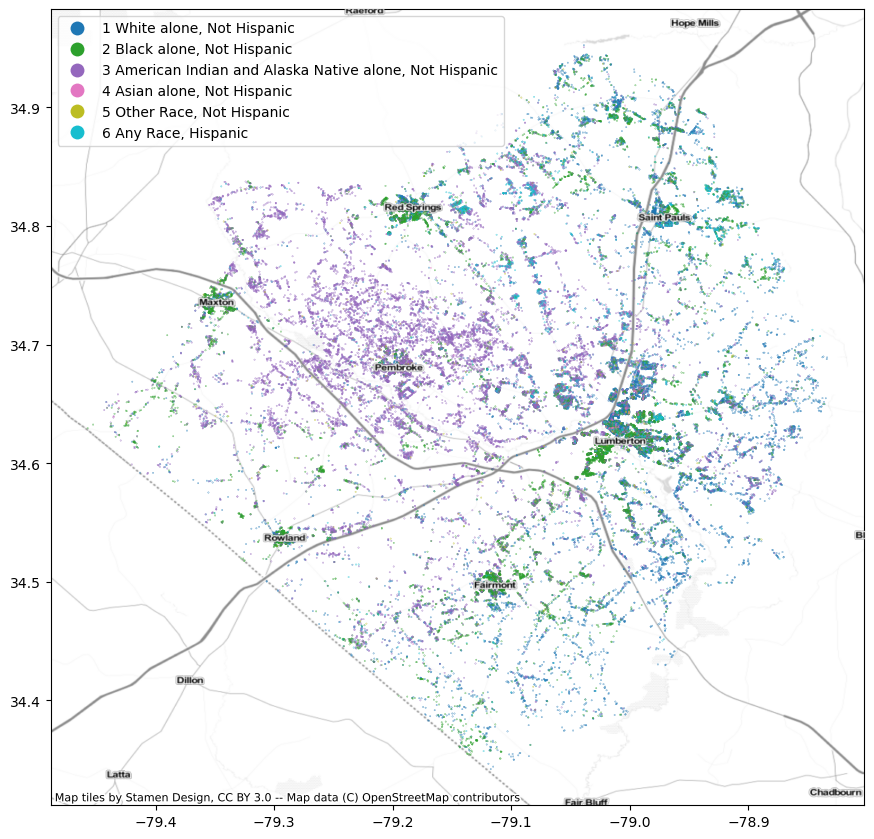

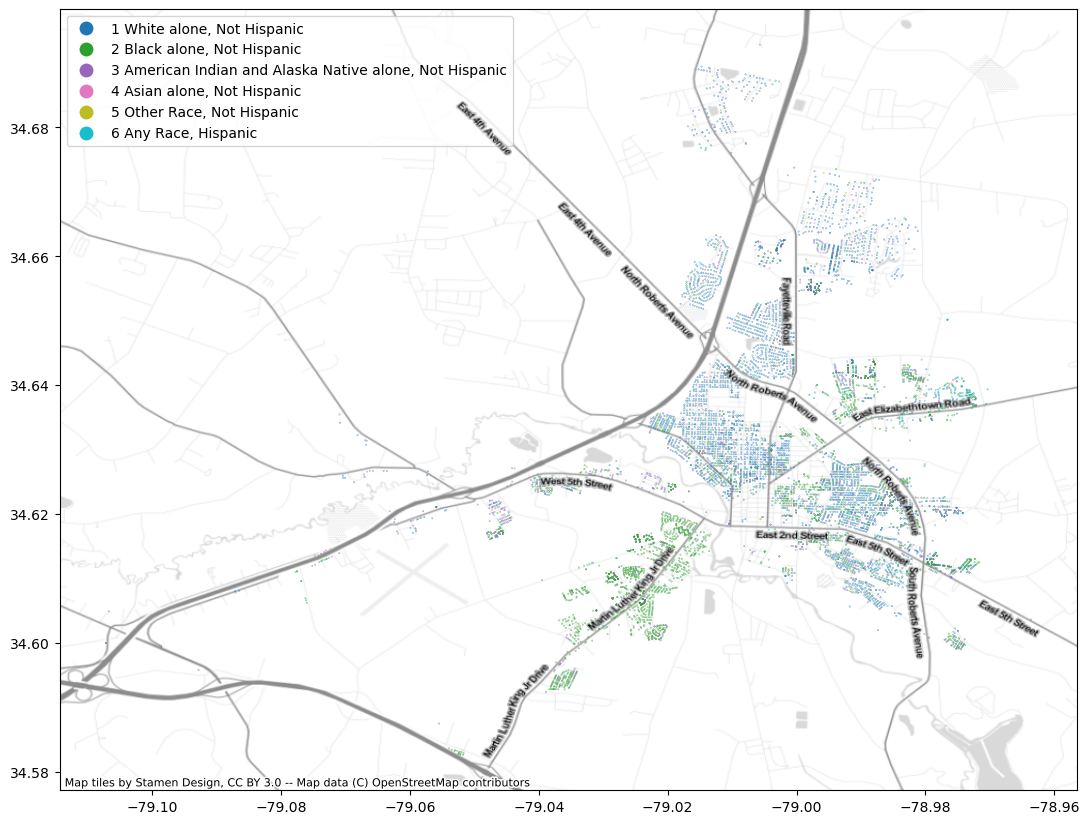

In [43]:
import contextily as cx # For adding basemap tiles to plot
import matplotlib.pyplot as plt # For plotting and making graphs

condition1 = "(hua_hui_race_gdf.race >= 1)"
place = 'Lumberton'
condition2 = f"(hua_hui_race_gdf.placeNAME10 == '{place}')"

condition_list = {1 : f"{condition1}",
                  2 : f"{condition1} & {condition2}" 
                } 

for item in condition_list.keys():
    condition =  condition_list[item]
    # Obtain data
    popdata = hua_hui_race_gdf.loc[eval(condition)].copy(deep=True)
    hua_data = popdata.to_crs(epsg=4326)

    # Set save file
    mapname = 'racedotmap'
    # save hua_hui_gdf to csv
    check_folder = f"{outputfolder}/{community}/06_Explore"
    output_filename = f'{mapname}_{community}_{place}'
    filepath = check_folder+"/"+output_filename

    ''' Need to sort out figure and axes
    # Set figure size (width, height) in inches
    #plt.figure(figsize = ( 14 , 12 ))
    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True

    # Figure Title
    by_label = "Race Ethnicity"
    who = f"Housing Unit Locations"
    what = f"by {by_label}"
    where = "Lumberton, NC"
    when = "2010"
    table_title = who +" "+ what+", \n "+ where +", "+ when +"."


    # Set title for figure
    plt.title( table_title, size = 18)

    notes = "notes here"
    plt.gcf().text(0, 0, notes, 
                            va = 'bottom', ha='left',
                            fontstyle='italic', size=6)
    '''

    plt.rcParams["figure.figsize"] = [11.00, 8.5]
    plt.rcParams["figure.autolayout"] = True
    
    # Plot the data
    ax = hua_data.plot(column='Race Ethnicity',
                        categorical=True, 
                        legend=True, 
                        markersize = 0.05)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLite)
    cx.add_basemap(ax, crs = hua_data.crs, 
            source=cx.providers.Stamen.TonerLabels)

    ax.figure.savefig(filepath+'v2.svg', 
                bbox_inches="tight",format = 'svg', 
                dpi=600)

    ax.figure.savefig(filepath+'v2.png', 
                bbox_inches="tight",format = 'png', 
                dpi=600)
